### <center>    San Jose State University<br>Department of Applied Data Science</center>
##  <center>    DATA 245 Sec 21<br>Machine Learning Technologies 
###  <center>   Group 4: Nupur Pathak, Revathi Boopathi, Sree Divya Cheerla, Vani Bhat




## **Credit Card Fraud Detection**


In [540]:
# Required installations
# !pip install imbalanced-learn
# !pip install sklearn
# !pip install haversine

In [541]:
# importing the required libraries
import pandas as pd
import glob
from pandas.plotting import scatter_matrix
import statistics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re 
import os
import datetime
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## I. Business Understanding

* The objective of this project is to detect fraudulent credit card transactions and discuss how such frauds can be handled by employing various Machine Learning algorithms.
* Credit card usage has increased tremendously over the decade which revolutionized the cashless payment methods, but it comes with its own set of risks.
* To tackle this issue, we plan to employ Machine Learning models like Logistic Regression, Naive Bayes, KNN, Random Forest, XG Boost, SVM, and deep learning model. We will compare the performance of each model to identify the best fitting model which can help reduce fraudulent transactions. 

## II. Data Understanding

#### II.a. Collect and Store Dataset

- The synthetic data for credit card transactions for 1,000 customers is generated using the Sparkov_Data_Generation-master.
- All the transactions are created for the duration January 1, 2020 to December 31, 2021.
- The generator creates a csv file for each customer will all transactions for the given customer for the given time span.
- We will take the union of all the transactions in these csv files and load in the dataframe for our analysis. 
- The data collected from the generator is collated and stored in 'Concat.csv' on the google drive. Refer to Data_Collection_Sparkov.pynb for data generation and collation. 

In [542]:
# Mounting the Google drive to get access in Google Colab. This step is not required if using Jupyter Notebook
# from google.colab import drive

# drive.mount('/content/gdrive/', force_remount=True)

In [543]:
# Loading the dataset
df = pd.read_csv('/Users/vanibhat/Documents/SJSU-Spring2022/DATA245-MachineLearning/Project/Concat.csv', index_col = 0)
df.head(2)

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,...,trans_num,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long
0,195-33-0728,3508835615951480,Ellen,Ortiz,F,482 Robert Light Apt. 994,Columbia Falls,ME,4623,44.6699,...,5c15602a5cf809764ed5d149a78e279a,2021-04-29,00:07:35,1.619680e+09,gas_transport,6.73,1.0,"fraud_Jenkins, Hauck and Friesen",44.084527,-67.954129
1,195-33-0728,3508835615951480,Ellen,Ortiz,F,482 Robert Light Apt. 994,Columbia Falls,ME,4623,44.6699,...,549fffa7671e25c7a183f2952ccff999,2021-04-29,07:10:46,1.619705e+09,gas_transport,12.74,1.0,"fraud_Zieme, Bode and Dooley",45.584705,-67.692301


#### II.b. 3 V (Volume, Variety, Velocity) of the data

In [544]:
# Volume: To print the number of rows and columns in the dataset
df.shape

(1752721, 26)

In [545]:
# Variety: Printing the information in the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1752721 entries, 0 to 1752720
Data columns (total 26 columns):
 #   Column      Dtype  
---  ------      -----  
 0   ssn         object 
 1   cc_num      int64  
 2   first       object 
 3   last        object 
 4   gender      object 
 5   street      object 
 6   city        object 
 7   state       object 
 8   zip         int64  
 9   lat         float64
 10  long        float64
 11  city_pop    int64  
 12  job         object 
 13  dob         object 
 14  acct_num    int64  
 15  profile     object 
 16  trans_num   object 
 17  trans_date  object 
 18  trans_time  object 
 19  unix_time   float64
 20  category    object 
 21  amt         float64
 22  is_fraud    float64
 23  merchant    object 
 24  merch_lat   float64
 25  merch_long  float64
dtypes: float64(7), int64(4), object(15)
memory usage: 361.0+ MB


In [546]:
# Printing the descriptive statistics for the dataset
df.describe()

,cc_num,zip,lat,long,city_pop,acct_num,unix_time,amt,is_fraud,merch_lat,merch_long
count,1.752721e+06,1.752721e+06,1.752721e+06,1.752721e+06,1.752721e+06,1.752721e+06,1.751721e+06,1.751721e+06,1.751721e+06,1.751721e+06,1.751721e+06
mean,3.843047e+17,5.121929e+04,3.755229e+01,-9.171316e+01,3.154471e+05,4.987205e+11,1.611112e+09,7.051059e+01,5.314773e-03,3.755235e+01,-9.171333e+01
std,1.257718e+18,2.977578e+04,5.158298e+00,1.640430e+01,6.226473e+05,2.859440e+11,1.822508e+07,1.666364e+02,7.270852e-02,5.190740e+00,1.641442e+01
min,6.040616e+10,1.040000e+03,2.132950e+01,-1.593448e+02,1.760000e+02,2.348758e+09,1.577866e+09,1.000000e+00,0.000000e+00,2.032995e+01,-1.603443e+02
25%,1.800159e+14,2.729200e+04,3.387960e+01,-9.862490e+01,1.924000e+04,2.720987e+11,1.595429e+09,9.020000e+00,0.000000e+00,3.383905e+01,-9.865916e+01
50%,3.516698e+15,4.830900e+04,3.861910e+01,-8.662130e+01,6.016300e+04,4.956758e+11,1.609552e+09,4.385000e+01,0.000000e+00,3.848595e+01,-8.652043e+01
75%,4.514627e+15,7.770700e+04,4.150220e+01,-7.953990e+01,2.141120e+05,7.408025e+11,1.627089e+09,8.126000e+01,0.000000e+00,4.150950e+01,-7.944400e+01
max,4.986227e+18,9.950700e+04,6.115350e+01,-6.775340e+01,2.906700e+06,9.993899e+11,1.641024e+09,2.205483e+04,1.000000e+00,6.215252e+01,-6.675340e+01


In [547]:
# Velocity: We have generated the synthetic data once using the Sparkov Generator. This is a static one-time generated data.

#### II.c. Creating new calculated fields required for the analysis

1. Getting the area( urban/rural) from profile feature
2. Creating a new column with age calculated from the dob feature
3. Calculating distance between customer location and merchant location using latitude and longitude features
4. Extracting date and time from trans_date and trans_time features


In [548]:
# 1. Getting the area( urban/rural) from profile
df['area'] = df['profile'].str[-10 : -5]
df.head()

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,...,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long,area
0,195-33-0728,3508835615951480,Ellen,Ortiz,F,482 Robert Light Apt. 994,Columbia Falls,ME,4623,44.6699,...,2021-04-29,00:07:35,1.619680e+09,gas_transport,6.73,1.0,"fraud_Jenkins, Hauck and Friesen",44.084527,-67.954129,rural
1,195-33-0728,3508835615951480,Ellen,Ortiz,F,482 Robert Light Apt. 994,Columbia Falls,ME,4623,44.6699,...,2021-04-29,07:10:46,1.619705e+09,gas_transport,12.74,1.0,"fraud_Zieme, Bode and Dooley",45.584705,-67.692301,rural
2,195-33-0728,3508835615951480,Ellen,Ortiz,F,482 Robert Light Apt. 994,Columbia Falls,ME,4623,44.6699,...,2021-04-29,10:09:12,1.619716e+09,gas_transport,9.53,1.0,fraud_Kling Inc,45.380492,-67.385962,rural
3,195-33-0728,3508835615951480,Ellen,Ortiz,F,482 Robert Light Apt. 994,Columbia Falls,ME,4623,44.6699,...,2021-04-29,09:15:39,1.619713e+09,grocery_pos,10.95,1.0,fraud_Miller-Hauck,45.350439,-67.644179,rural
4,195-33-0728,3508835615951480,Ellen,Ortiz,F,482 Robert Light Apt. 994,Columbia Falls,ME,4623,44.6699,...,2021-04-29,00:22:42,1.619681e+09,grocery_pos,353.18,1.0,fraud_McDermott-Weimann,45.424536,-67.852445,rural


In [549]:
# 2. Creating a new column with age calculated from the dob
now = datetime.datetime.now()
df['age'] = df.dob.apply(lambda x: now.year - datetime.datetime.strptime(x,'%Y-%m-%d').year )

In [550]:
# 3. Calculating distance between customer location and merchant location
lon1 = df["long"].astype(float)
lat1 = df["lat"].astype(float)
lon2 = df["merch_long"].astype(float)
lat2 = df["merch_lat"].astype(float)

In [551]:
# Defining the haversine_array function
def haversine_array(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    newlon = lon2 - lon1
    newlat = lat2 - lat1

    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    miles = round((3958 * dist),3) #6367 for distance in KM for miles use 3958
    return miles

df['distance'] = haversine_array(df['lat'], df['long'],df['merch_lat'], df['merch_long'])

In [552]:
# 4. Extracting date and time from trans_date, trans_time
df['trans_date'] = pd.to_datetime(df['trans_date'])
df['trans_time'] = pd.to_datetime(df['trans_time'],format='%H:%M:%S')
df['month'] = df['trans_date'].dt.month.astype('Int64')
df['is_weekend'] = df.trans_date.dt.day_of_week.apply(lambda x: 1 if (x in [5,6]) else 0)
df['hour'] = df['trans_time'].dt.hour.astype('Int64')

In [553]:
# 5. Identifying the holiday months (November, December)
def month_categ(x):
    try:
        if (x==11) or (x==12):
          return 1
        else: return 2
    except Exception as err: pass

In [554]:
df['hol_month']=df['month'].apply(month_categ)

In [555]:
# 6. Fetching the shopping frequency
df.sort_values(by=['ssn','trans_date'],inplace=True,ascending=[True,False])
df['recent_shop']=df.groupby(['ssn'])['trans_date'].shift()
df['recent_shop_gap']=df['trans_date']-df['recent_shop']
df['recent_shop_gap']=df['recent_shop_gap'].astype('str')
# Getting customers who have recently shopped
def shop_category(x):
    if x =='0 days':
        return 'recent'
    else: 
        return 'past'
df['recent_shopper']=df['recent_shop_gap'].apply(shop_category)


In [556]:
# 7. Identifying locations which are suspicious to fraud 
# Flagging latitude based on how suspicious they are
def lat_long_category(x):
    if x <=8:
        return 1 #non-suspicious
    elif x <= 12:
        return 2 #mod-suspicious
    else: 
        return 3 #suspicious

df['lat_long']=df['lat']+df['long']
df_inter=df.groupby(['lat_long'])['is_fraud'].sum().reset_index().sort_values(by='is_fraud',ascending=False)
df_inter['lat_long_type']=df_inter['is_fraud'].apply(lat_long_category)
df=pd.merge(df,df_inter[['lat_long','lat_long_type']],how='inner',on='lat_long')

In [557]:
# 8. Identifying the categories with high prevalance of fradulent incidents 
def genuine_categ(x):
    if x <=186:
        return 1
    elif x <= 1008:
        return 2
    else:
        return 3

df_categ_inter=df.groupby(['category'])['is_fraud'].sum().reset_index(name='category_fraud').sort_values(by='category_fraud',ascending=False)
df_categ_inter['categ_type']=df_categ_inter['category_fraud'].apply(genuine_categ)
df=pd.merge(df,df_categ_inter[['category','categ_type']],how='inner',on='category')

In [558]:
# 9. Clubbing times of the day
def hour_categ(x):
    if (x==22) or (x==23) or ((x>=0) and (x<=3)):
        return 'midnight'
    else:
        return 'daylight'
df['hour_type']=df['hour'].apply(hour_categ)

In [559]:
# Verifying the newly created features
df.head(2)

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,...,is_weekend,hour,hol_month,recent_shop,recent_shop_gap,recent_shopper,lat_long,lat_long_type,categ_type,hour_type
0,001-28-0753,4661995305641840,Pamela,Lee,F,467 Wayne Neck Apt. 187,Beverly,MA,1915,42.5608,...,0,23,1.0,NaT,NaT,past,-28.3151,1,3,midnight
1,001-28-0753,4661995305641840,Pamela,Lee,F,467 Wayne Neck Apt. 187,Beverly,MA,1915,42.5608,...,0,12,1.0,2021-11-16,0 days,recent,-28.3151,1,3,daylight


In [560]:
# df_org = df.copy()
df.columns

Index(['ssn', 'cc_num', 'first', 'last', 'gender', 'street', 'city', 'state',
       'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'acct_num', 'profile',
       'trans_num', 'trans_date', 'trans_time', 'unix_time', 'category', 'amt',
       'is_fraud', 'merchant', 'merch_lat', 'merch_long', 'area', 'age',
       'distance', 'month', 'is_weekend', 'hour', 'hol_month', 'recent_shop',
       'recent_shop_gap', 'recent_shopper', 'lat_long', 'lat_long_type',
       'categ_type', 'hour_type'],
      dtype='object')

#### II.d. Exploratory Data Analysis (EDA)

In [561]:
# Checking for missing values in the dataset
for col in df.columns:
    null = df[col].isnull().values.any()
    print(f"{col}: {df[col].isna().values.any()}")

ssn: False
cc_num: False
first: False
last: False
gender: False
street: False
city: False
state: False
zip: False
lat: False
long: False
city_pop: False
job: False
dob: False
acct_num: False
profile: False
trans_num: False
trans_date: False
trans_time: False
unix_time: False
category: False
amt: False
is_fraud: False
merchant: False
merch_lat: False
merch_long: False
area: False
age: False
distance: False
month: False
is_weekend: False
hour: False
hol_month: False
recent_shop: True
recent_shop_gap: False
recent_shopper: False
lat_long: False
lat_long_type: False
categ_type: False
hour_type: False


- We see that there are multiple columns with missing values in the dataset. We will handle these in the data preparation stage
- We see that there are 9,310 instances of fraudulent transactions

0.0    1742411
1.0       9310
Name: is_fraud, dtype: int64



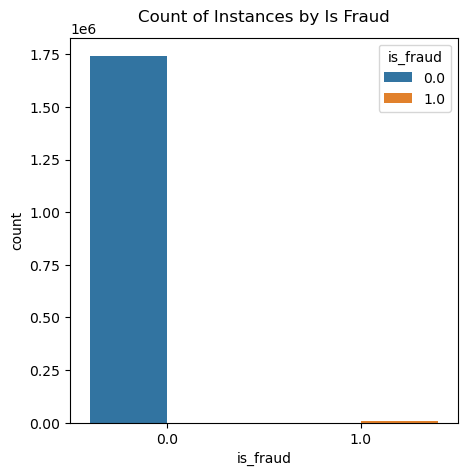

In [562]:
# Printing the target feature distribution in the dataset
print(df.is_fraud.value_counts())
print()
plt.figure(figsize = (5,5))
plt.title("Count of Instances by Is Fraud", y=1.02)
sns.countplot(x=df.is_fraud, data = df,hue = df.is_fraud)
plt.show()

- We see that the number of non-fraudulent transactions(99.5%) is higher as compared to the fradulent transactions(0.5%). Therefore, this is an imbalanced dataset. We will perform various sampling methods on our dataset in the following sections.

In [563]:
# df = df_org
df.columns

Index(['ssn', 'cc_num', 'first', 'last', 'gender', 'street', 'city', 'state',
       'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'acct_num', 'profile',
       'trans_num', 'trans_date', 'trans_time', 'unix_time', 'category', 'amt',
       'is_fraud', 'merchant', 'merch_lat', 'merch_long', 'area', 'age',
       'distance', 'month', 'is_weekend', 'hour', 'hol_month', 'recent_shop',
       'recent_shop_gap', 'recent_shopper', 'lat_long', 'lat_long_type',
       'categ_type', 'hour_type'],
      dtype='object')

In [564]:
# Drop the columns that are not necessary for the model development
df=df[['gender','city_pop','amt','is_fraud','area','age','distance','hol_month','is_weekend','hour_type','recent_shopper',\
   'lat_long_type','categ_type']]

In [565]:
# Printing the columns used in modeling
df.columns

Index(['gender', 'city_pop', 'amt', 'is_fraud', 'area', 'age', 'distance',
       'hol_month', 'is_weekend', 'hour_type', 'recent_shopper',
       'lat_long_type', 'categ_type'],
      dtype='object')

### Data Quality Report for Continuous Features

In [566]:
# Creating a dataframe with continuous attributes in the data table
df_cont = df[['city_pop','amt', 'age', 'distance']].copy()
df_cont.head()

,city_pop,amt,age,distance
0,39502,317.35,95,25.136
1,39502,880.85,95,7.231
2,39502,962.98,95,14.856
3,8399,816.18,57,35.963
4,8399,1034.97,57,45.031


In [567]:
# Datatypes of continuous features
df_cont.dtypes

city_pop      int64
amt         float64
age           int64
distance    float64
dtype: object

In [568]:
# Converting the data type of 'city_pop' feature to float
df_cont.city_pop = df_cont['city_pop'].astype(float)

In [569]:
# Computing the fields for the Data Quality Report
data_types = pd.DataFrame(df_cont.dtypes,
                          columns=['Data Type'])

total_count = pd.DataFrame(df_cont.count(),
                                   columns=['Count'])

percentage_missing = pd.DataFrame(df_cont.isnull().sum()/len(df)*100,
                                   columns=['%Miss'])

cardinality = pd.DataFrame(columns=['Cardinality'])
for v in list(df_cont.columns.values):
    cardinality.loc[v] = [df_cont[v].nunique()]
    
minimum = pd.DataFrame(columns=['Min'])
for v in list(df_cont.columns.values):
    minimum.loc[v] = [df_cont[v].min()]
    
first_quartile = pd.DataFrame(columns=['1st Qrt'])
for v in list(df_cont.columns.values):
    first_quartile.loc[v] = [df_cont[v].quantile(0.25)]
    
mean = pd.DataFrame(columns=['Mean'])
for v in list(df_cont.columns.values):
    mean.loc[v] = [df_cont[v].mean()]
    
median = pd.DataFrame(columns=['Median'])
for v in list(df_cont.columns.values):
    median.loc[v] = [df_cont[v].median()]
    
third_quartile = pd.DataFrame(columns=['3rd Qrt'])
for v in list(df_cont.columns.values):
    third_quartile.loc[v] = [df_cont[v].quantile(0.75)]
    
maximum = pd.DataFrame(columns=['Max'])
for v in list(df_cont.columns.values):
    maximum.loc[v] = [df_cont[v].max()]
    
stddev = pd.DataFrame(columns=['Std_Dev'])
for v in list(df_cont.columns.values):
    stddev.loc[v] = [df_cont[v].std()]

In [570]:
# Concatinating the fields for the Data Quality Report
data_quality_report = data_types.join(total_count).join(percentage_missing).join(cardinality).join(minimum).join(first_quartile).join(mean).join(median).join(third_quartile).join(maximum).join(stddev)
print("\nData Quality Report")
print("Total records: {}".format(len(data_quality_report.index)))
data_quality_report.round(2)


Data Quality Report
Total records: 4


,Data Type,Count,%Miss,Cardinality,Min,1st Qrt,Mean,Median,3rd Qrt,Max,Std_Dev
city_pop,float64,1751721,0.0,798,176.00,19240.00,315454.76,60163.00,214112.00,2906700.00,622657.87
amt,float64,1751721,0.0,60327,1.00,9.02,70.51,43.85,81.26,22054.83,166.64
age,int64,1751721,0.0,81,15.00,31.00,44.66,43.00,56.00,96.00,17.43
distance,float64,1751721,0.0,75368,0.02,20.53,36.69,36.44,53.03,92.98,19.08


In [571]:
# Plotting the correlation matrix for the continuous features in the dataset
df_correlation = df.corr(method = 'pearson')
df_correlation

,city_pop,amt,is_fraud,age,distance,hol_month,is_weekend,lat_long_type,categ_type
city_pop,1.000000,-0.000740,-0.001707,0.023788,-0.004023,-0.000164,-0.002783,-0.005458,-0.001210
amt,-0.000740,1.000000,0.207886,0.006935,-0.000236,0.013112,-0.003336,-0.006448,0.024179
is_fraud,-0.001707,0.207886,1.000000,0.021538,-0.000451,0.009501,-0.014363,0.015112,0.057179
age,0.023788,0.006935,0.021538,1.000000,-0.001763,-0.000371,-0.017083,-0.085162,0.006088
distance,-0.004023,-0.000236,-0.000451,-0.001763,1.000000,0.000613,-0.001359,-0.002281,0.000553
hol_month,-0.000164,0.013112,0.009501,-0.000371,0.000613,1.000000,0.024383,0.000905,-0.160897
is_weekend,-0.002783,-0.003336,-0.014363,-0.017083,-0.001359,0.024383,1.000000,0.011089,-0.001180
lat_long_type,-0.005458,-0.006448,0.015112,-0.085162,-0.002281,0.000905,0.011089,1.000000,-0.003017
categ_type,-0.001210,0.024179,0.057179,0.006088,0.000553,-0.160897,-0.001180,-0.003017,1.000000


<AxesSubplot:>

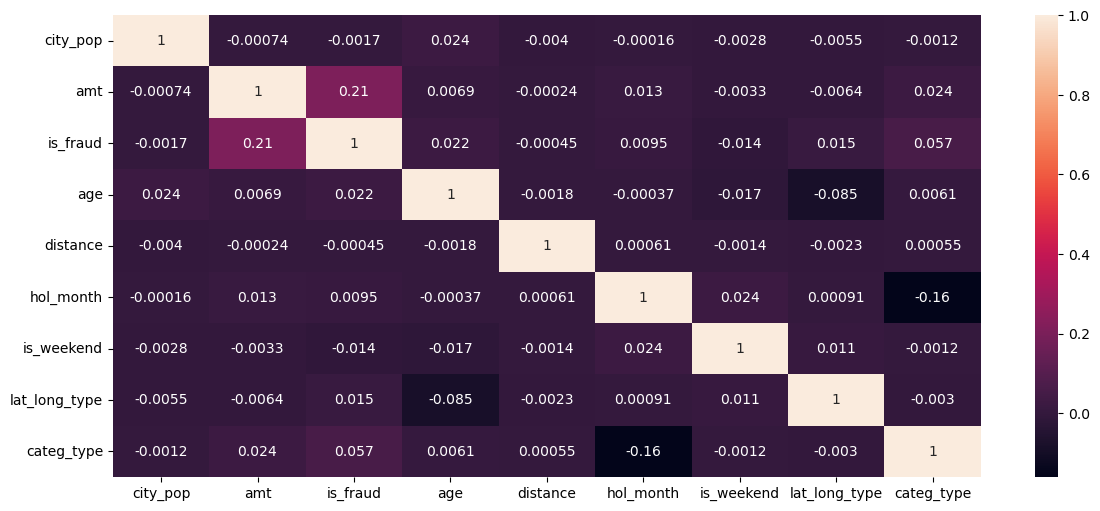

In [572]:
import seaborn as sns
%matplotlib inline
# Plotting the correlation matrix for the continuous features in the dataset
# plot the heatmap
fig, ax = plt.subplots(figsize=(14,6)) 
sns.heatmap(df_correlation,annot=True, 
        xticklabels=df_correlation.columns,
        yticklabels=df_correlation.columns)

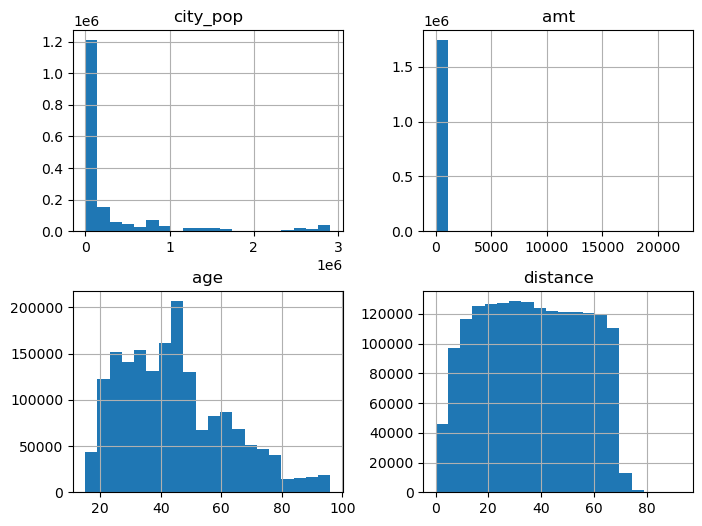

In [573]:
# Plotting the histograms for the continuous attributes in the dataset 
%matplotlib inline 

df_cont.hist(bins=20, figsize = (8,6))
plt.show()


<AxesSubplot:>

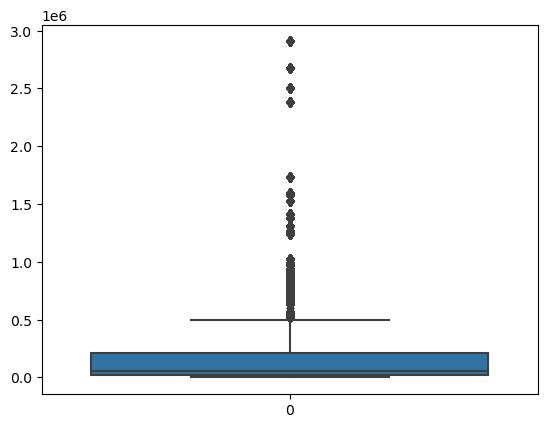

In [574]:
sns.boxplot(data = df_cont['city_pop'])

<AxesSubplot:>

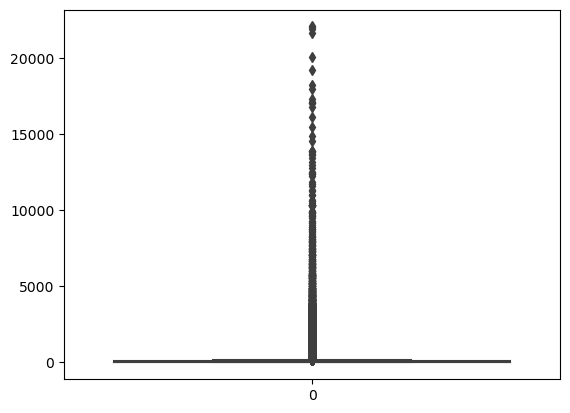

In [575]:
sns.boxplot(data = df_cont['amt'])

<AxesSubplot:>

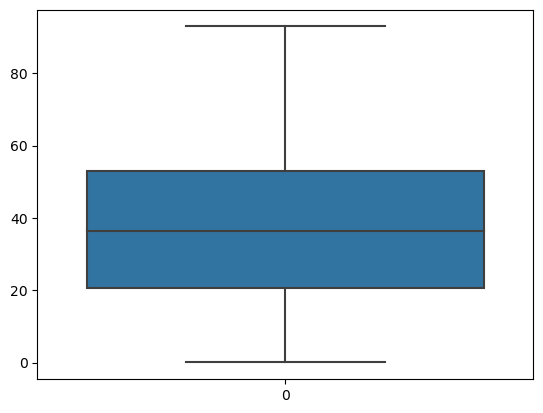

In [576]:
sns.boxplot(data = df_cont['distance'])

<AxesSubplot:>

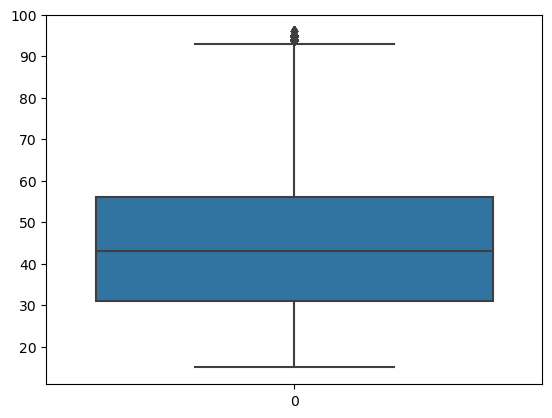

In [577]:
sns.boxplot(data = df_cont['age'])

### Data Quality Report for Categorical Features

In [578]:
# Creating a dataframe with categorical features in the data table
df_categ = df[['gender', 'is_fraud', 'area', 'hol_month', 'is_weekend', 'hour_type', 'recent_shopper', 'lat_long_type', 'categ_type']].copy()
df_categ.head()

,gender,is_fraud,area,hol_month,is_weekend,hour_type,recent_shopper,lat_long_type,categ_type
0,F,1.0,urban,1.0,0,midnight,past,1,3
1,F,1.0,urban,1.0,0,daylight,recent,1,3
2,F,1.0,urban,1.0,0,midnight,recent,1,3
3,F,1.0,urban,2.0,0,midnight,recent,2,3
4,F,1.0,urban,2.0,0,daylight,recent,2,3


In [579]:
# Printing the information of the categorical features
df_categ.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751721 entries, 0 to 1751720
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   gender          object 
 1   is_fraud        float64
 2   area            object 
 3   hol_month       float64
 4   is_weekend      int64  
 5   hour_type       object 
 6   recent_shopper  object 
 7   lat_long_type   int64  
 8   categ_type      int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 133.6+ MB


In [580]:
# Converting the data type of the features to string
df_categ = df_categ.astype(str)

In [581]:
# Computing the fields for the Data Quality Report
data_types = pd.DataFrame(df_categ.dtypes,
                          columns=['Data Type'])

total_count = pd.DataFrame(df_categ.count(),
                                   columns=['Count'])

percentage_missing = pd.DataFrame(df_categ.isnull().sum()/len(df)*100,
                                   columns=['%Miss'])

cardinality = pd.DataFrame(columns=['Cardinality'])
for v in list(df_categ.columns.values):
    cardinality.loc[v] = [df_categ[v].nunique()]
    
mode = pd.DataFrame(columns=['Mode'])
for v in list(df_categ.columns.values):
    mode.loc[v] = [df_categ[v].value_counts().index.tolist()[0]]
    
mode_freq = pd.DataFrame(columns=['Mode Freq'])
for v in list(df_categ.columns.values):
    mode_freq.loc[v] = [df_categ[v].value_counts()[0]]

mode_perc = pd.DataFrame(columns=['Mode Perc'])
for v in list(df_categ.columns.values):
    mode_perc.loc[v] = [df_categ[v].value_counts()[0]/len(df_categ['gender'])*100]    
    
smode = pd.DataFrame(columns=['Second Mode'])
for v in list(df_categ.columns.values):
    smode.loc[v] = [df_categ[v].value_counts().index.tolist()[1]]
    
smode_freq = pd.DataFrame(columns=['Second Mode Freq'])
for v in list(df_categ.columns.values):
    smode_freq.loc[v] = [df_categ[v].value_counts()[1]]

smode_perc = pd.DataFrame(columns=['Second Mode Perc'])
for v in list(df_categ.columns.values):
    smode_perc.loc[v] = [df_categ[v].value_counts()[1]/len(df_categ['gender'])*100]  

In [582]:
# Concatinating the fields in the Data Quality Report
data_quality_report2 = data_types.join(total_count).join(percentage_missing).join(cardinality).join(mode).join(mode_freq).join(mode_perc).join(smode).join(smode_freq).join(smode_perc)
print("\nData Quality Report - Categorical Features")
print("Total records: {}".format(len(data_quality_report2.index)))
data_quality_report2


Data Quality Report - Categorical Features
Total records: 9


,Data Type,Count,%Miss,Cardinality,Mode,Mode Freq,Mode Perc,Second Mode,Second Mode Freq,Second Mode Perc
gender,object,1751721,0.0,2,M,895503,51.121326,F,856218,48.878674
is_fraud,object,1751721,0.0,2,0.0,1742411,99.468523,1.0,9310,0.531477
area,object,1751721,0.0,2,urban,1680714,95.946444,rural,71007,4.053556
hol_month,object,1751721,0.0,2,2.0,1358082,77.528442,1.0,393639,22.471558
is_weekend,object,1751721,0.0,2,0,1055304,60.243840,1,696417,39.756160
hour_type,object,1751721,0.0,2,daylight,1342626,76.646110,midnight,409095,23.353890
recent_shopper,object,1751721,0.0,2,recent,1218395,69.554170,past,533326,30.445830
lat_long_type,object,1751721,0.0,3,2,810978,46.296071,1,637355,36.384504
categ_type,object,1751721,0.0,3,2,833343,47.572816,3,546081,31.173971


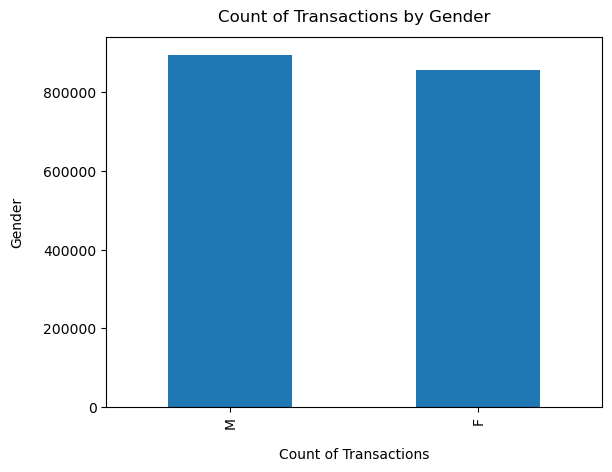

In [583]:
df.gender.value_counts().plot(kind="bar")
plt.xlabel("Count of Transactions", labelpad=14)
plt.ylabel("Gender", labelpad=14)
plt.title("Count of Transactions by Gender", y=1.02);

<AxesSubplot:>

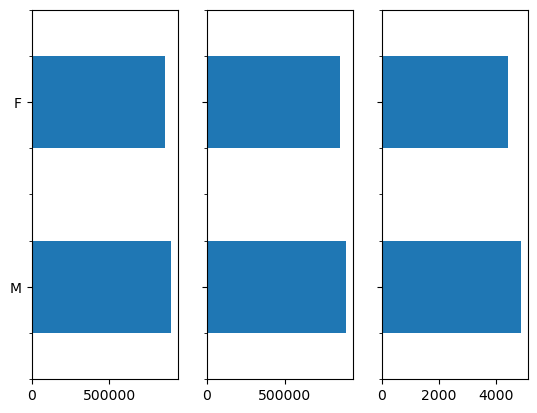

In [584]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
df.gender.value_counts().plot(kind="barh", ax = ax1)
df[df.is_fraud == 0].gender.value_counts().plot(kind="barh", ax = ax2)
df[df.is_fraud == 1].gender.value_counts().plot(kind="barh", ax = ax3)

<AxesSubplot:>

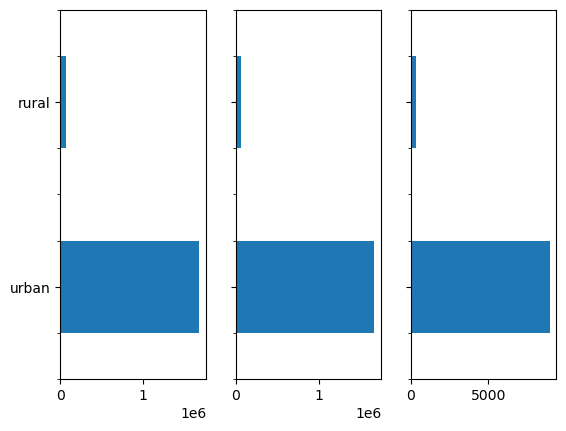

In [585]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
df.area.value_counts().plot(kind="barh", ax = ax1)
df[df.is_fraud == 0].area.value_counts().plot(kind="barh", ax = ax2)
df[df.is_fraud == 1].area.value_counts().plot(kind="barh", ax = ax3)

<AxesSubplot:>

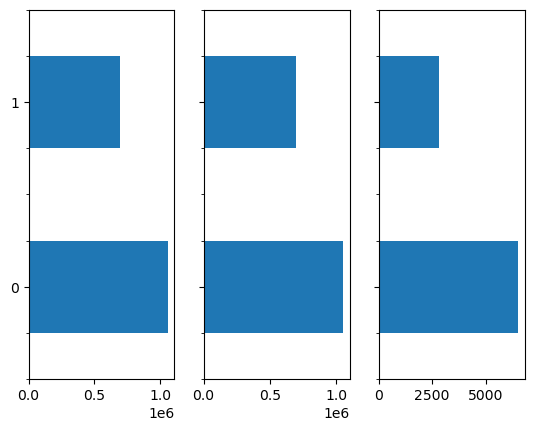

In [586]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
df.is_weekend.value_counts().plot(kind="barh", ax = ax1)
df[df.is_fraud == 0].is_weekend.value_counts().plot(kind="barh", ax = ax2)
df[df.is_fraud == 1].is_weekend.value_counts().plot(kind="barh", ax = ax3)

## III. Data Preparation

### III.a. Data Cleaning

In [587]:
# Checking for missing values in the dataset
for col in df.columns:
    null = df[col].isnull().values.any()
    print(f"{col}: {df[col].isna().values.any()}")

gender: False
city_pop: False
amt: False
is_fraud: False
area: False
age: False
distance: False
hol_month: False
is_weekend: False
hour_type: False
recent_shopper: False
lat_long_type: False
categ_type: False


In [588]:
# Drop the instances have all null values present in the dataset
df.dropna(axis = 0, how='all', inplace = True)

# Checking for missing values in the dataset
for col in df.columns:
    null = df[col].isnull().values.any()
    print(f"{col}: {df[col].isna().values.any()}")

gender: False
city_pop: False
amt: False
is_fraud: False
area: False
age: False
distance: False
hol_month: False
is_weekend: False
hour_type: False
recent_shopper: False
lat_long_type: False
categ_type: False


In [589]:
# Removing the entries where the target feature is not available as this is required for our modeling
df.dropna(axis = 0, how='any', inplace = True) # Considered for all instances having null values in either features

In [590]:
# Checking for missing values in the dataset
for col in df.columns:
    null = df[col].isnull().values.any()
    print(f"{col}: {df[col].isna().values.any()}")

gender: False
city_pop: False
amt: False
is_fraud: False
area: False
age: False
distance: False
hol_month: False
is_weekend: False
hour_type: False
recent_shopper: False
lat_long_type: False
categ_type: False


- All the missing value fields are eliminated from the dataframe

In [591]:
# Check for duplicates
df.duplicated().value_counts()

False    1751721
dtype: int64

- Here we see there are no duplicate instances in the dataset

#### IV.a. Data Transformation (Feature Engineering)

- The dataset consists of many categorical features. However, many of the machine learning models usually require numerical values as the input. Hence, necessary transformatin of data from categorical to numerical is must.In this section, we take multiple measures to convert data to make it suitable for modelling.

In [592]:
#Below are the different features in the dataset
df.columns

Index(['gender', 'city_pop', 'amt', 'is_fraud', 'area', 'age', 'distance',
       'hol_month', 'is_weekend', 'hour_type', 'recent_shopper',
       'lat_long_type', 'categ_type'],
      dtype='object')

In [593]:
# sample dataframe after dropping unnecessary columns
df.head()

,gender,city_pop,amt,is_fraud,area,age,distance,hol_month,is_weekend,hour_type,recent_shopper,lat_long_type,categ_type
0,F,39502,317.35,1.0,urban,95,25.136,1.0,0,midnight,past,1,3
1,F,39502,880.85,1.0,urban,95,7.231,1.0,0,daylight,recent,1,3
2,F,39502,962.98,1.0,urban,95,14.856,1.0,0,midnight,recent,1,3
3,F,8399,816.18,1.0,urban,57,35.963,2.0,0,midnight,recent,2,3
4,F,8399,1034.97,1.0,urban,57,45.031,2.0,0,daylight,recent,2,3


#### IV.b. Data Transformation

In [594]:
# Label Encoding
from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()

df['categ_type']=label_encoder.fit_transform(df['categ_type'])
df['lat_long_type']=label_encoder.fit_transform(df['lat_long_type'])

In [595]:
df.columns

Index(['gender', 'city_pop', 'amt', 'is_fraud', 'area', 'age', 'distance',
       'hol_month', 'is_weekend', 'hour_type', 'recent_shopper',
       'lat_long_type', 'categ_type'],
      dtype='object')

In [596]:
# Finding dependency with the target variable using chi-squared test statistics
cols=['gender','area','hol_month','is_weekend','hour_type','recent_shopper','lat_long_type','categ_type']
for i in df[cols]:
    data_interim=df[[i, 'is_fraud']]

    data_cont=pd.crosstab(data_interim[i],data_interim['is_fraud'])

    from scipy.stats import chi2_contingency
    stat, p, dof, expected = chi2_contingency(data_cont)

    #-----------interpret p-value
    alpha = 0.05
    print(i,p,p<alpha)

gender 0.011816646789754925 True
area 0.9952116981974969 False
hol_month 3.384267476615273e-36 True
is_weekend 1.711962979716311e-80 True
hour_type 0.0 True
recent_shopper 1.9626976385969158e-90 True
lat_long_type 4.8147231182969436e-111 True
categ_type 0.0 True


In [597]:
# One-hot Encoding 
df = pd.get_dummies(df, columns = ['gender', 'area','hour_type','recent_shopper'])

In [598]:
# Selecting only the valuable fields
df.drop(['gender_F','area_urban','hour_type_daylight','recent_shopper_past','area_urban','area_rural'],axis=1,inplace=True)

In [599]:
# sample dataframe after one hot encoding of gender and category variable
df.head(5)

,city_pop,amt,is_fraud,age,distance,hol_month,is_weekend,lat_long_type,categ_type,gender_M,hour_type_midnight,recent_shopper_recent
0,39502,317.35,1.0,95,25.136,1.0,0,0,2,0,1,0
1,39502,880.85,1.0,95,7.231,1.0,0,0,2,0,0,1
2,39502,962.98,1.0,95,14.856,1.0,0,0,2,0,1,1
3,8399,816.18,1.0,57,35.963,2.0,0,1,2,0,1,1
4,8399,1034.97,1.0,57,45.031,2.0,0,1,2,0,0,1


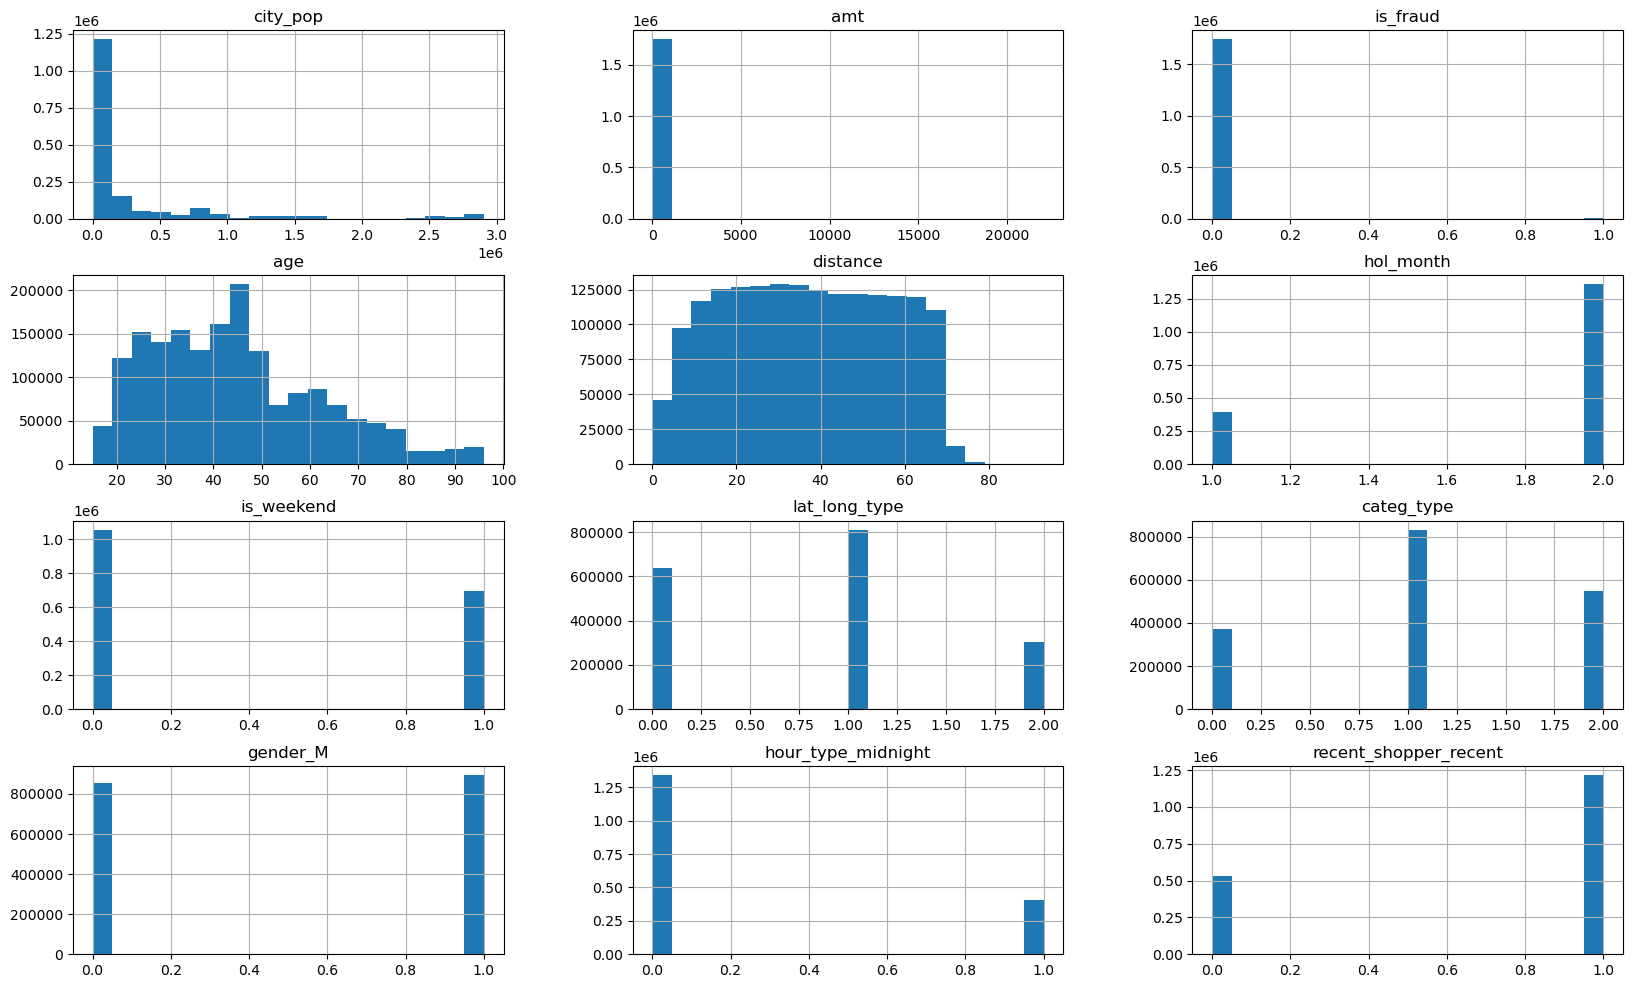

In [600]:
# Plotting the histograms for the continuous attributes in the dataset 
%matplotlib inline 

df.hist(bins=20, figsize = (20,12))
plt.show()

- From the above histogram, we can see that most of the distributions do not follow normal distribution

#### Data Scaling: Normalization

#### As the data here has not followed gaussian distribution, the standardisation has not been done. Instead Normalisation is done

In [601]:
 ## We are doing range normalisation only for the fields which includes wide variety of values.

for col in df.columns:
    x = df[col].unique()

In [602]:
# Range normalisation

# apply normalization techniques
for column in df.columns:
    df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())

# view normalized data
df.head()

,city_pop,amt,is_fraud,age,distance,hol_month,is_weekend,lat_long_type,categ_type,gender_M,hour_type_midnight,recent_shopper_recent
0,0.013530,0.014344,1.0,0.987654,0.270223,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.013530,0.039896,1.0,0.987654,0.077621,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.013530,0.043620,1.0,0.987654,0.159642,0.0,0.0,0.0,1.0,0.0,1.0,1.0
3,0.002829,0.036963,1.0,0.518519,0.386687,1.0,0.0,0.5,1.0,0.0,1.0,1.0
4,0.002829,0.046884,1.0,0.518519,0.484230,1.0,0.0,0.5,1.0,0.0,0.0,1.0


#### IV.c. Sampling

- As our data is imbalanced, we will be experimenting upsampling, downsampling, updownsampling, and SMOTE methods.

In [603]:
#separating fraud and non-fraud transaction
FraudDataset = df.loc[df['is_fraud'] == 1]
ValidDataset = df.loc[df['is_fraud'] == 0]

In [604]:
print('Count of fraudulent transations:', len(FraudDataset))
print('Count of non-fraudulent transations:', len(ValidDataset))

Count of fraudulent transations: 9310
Count of non-fraudulent transations: 1742411


In [605]:
#1) downsampling valid dataset to 9310 , total 18,620 records
#downsampling
from sklearn.utils import resample
valid_downsample = resample(ValidDataset,
             replace=True,
             n_samples= len(FraudDataset),
             random_state=42)

print(valid_downsample.shape)

(9310, 12)


In [606]:
#combining 2 datasets 
df2 = pd.concat([valid_downsample, FraudDataset])
print(df2['is_fraud'].value_counts())

0.0    9310
1.0    9310
Name: is_fraud, dtype: int64


<AxesSubplot:ylabel='Type'>

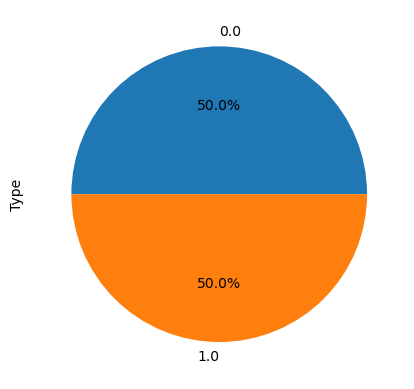

In [607]:
#plotting piechart after resampling
df2.groupby('is_fraud').size().plot(kind='pie',
                                       y = 'is_fraud',
                                       label = "Type",
                                       autopct='%1.1f%%')

In [608]:
X = df2.drop(labels='is_fraud', axis=1)
y = df2['is_fraud']
X.shape, y.shape

((18620, 11), (18620,))

In [609]:
#2)Upsampling fraud dataset to  17,42411 , total 3484822 records
# #upsampling
# from sklearn.utils import resample
# fraud_upsample = resample(FraudDataset,
#              replace=True,
#              n_samples=len(ValidDataset),
#              random_state=42)

# print(fraud_upsample.shape)

In [610]:
# #combining 2 datasets 
# df2 = pd.concat([fraud_upsample, ValidDataset])
# print(df2['is_fraud'].value_counts())

In [611]:
# #plotting piechart after resampling
# df2.groupby('is_fraud').size().plot(kind='pie',
#                                        y = 'is_fraud',
#                                        label = "Type",
#                                        autopct='%1.1f%%')

In [612]:
#3) upsampling and downsamplimg to some threhold  value say 50000
# #downsampling
# from sklearn.utils import resample
# valid_downsample = resample(ValidDataset,
#              replace=True,
#              n_samples= 50000,
#              random_state=42)

# print(valid_downsample.shape)

In [613]:
# #upsampling
# from sklearn.utils import resample
# fraud_upsample = resample(FraudDataset,
#              replace=True,
#              n_samples=len(valid_downsample),
#              random_state=42)

# print(fraud_upsample.shape)

In [614]:
# #combining 2 datasets 
# df2 = pd.concat([fraud_upsample, valid_downsample])
# print(df2['is_fraud'].value_counts())

In [615]:
# #plotting piechart after resampling
# df2.groupby('is_fraud').size().plot(kind='pie',
#                                        y = 'is_fraud',
#                                        label = "Type",
#                                        autopct='%1.1f%%')

In [616]:
#4) SMOTE - upsampling fraud dataset to 17,42411  - it might create noisy data by over sampling
# X = df.drop(labels='is_fraud', axis=1)
# y = df[['is_fraud']]

In [617]:
# su = SMOTE(random_state=42)

In [618]:
# su.fit_resample(X,y)

In [619]:
# X_su, y_su = su.fit_resample(X, y)

In [620]:
# #combining 2 datasets 
# df2 = pd.concat([X_su, y_su])
# print(df2['is_fraud'].value_counts())

In [621]:
# #plotting piechart after resampling
# y_su.groupby('is_fraud').size().plot(kind='pie',
#                                        y = 'is_fraud',
#                                        label = "Type",
#                                        autopct='%1.1f%%')

#### IV.d. Split data into Training and Testing

In [622]:
df = df.iloc[: , 1:]
df.head(2)

,amt,is_fraud,age,distance,hol_month,is_weekend,lat_long_type,categ_type,gender_M,hour_type_midnight,recent_shopper_recent
0,0.014344,1.0,0.987654,0.270223,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.039896,1.0,0.987654,0.077621,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [623]:
# # assigning features to X and target to y

# X = df[['city', 'city_pop', 'job', 'category', 'amt', 'merchant',
#        'distance', 'year', 'month', 'day_of_month', 'is_weekend', 'hour',
#        'gender_F', 'gender_M', 'age_category_adult', 'age_category_senior',
#        'age_category_young', 'area_rural', 'area_urban']]

# y = df.is_fraud

In [624]:
# splitting the dataset into training and testing set

from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(X, y, stratify=y,train_size=.80,shuffle = True, random_state= 42)

print(f'Training dataset : {xtrain.shape} {ytrain.shape}') # dimension of train set
print(f'Testing dataset : {xtest.shape}, {ytest.shape}') # dimension of test set

Training dataset : (14896, 11) (14896,)
Testing dataset : (3724, 11), (3724,)


#### IV.e. Dimentionality Reduction using PCA

In [625]:
# # Plotting scree plot to decide the number of principle components required
# # Experiment on whether standardization or normalization for PCA (mostly they use both, but need to read more)

# pca = PCA(n_components=10)

# #fit PCA model to data
# pca_fit = pca.fit(xtrain)

# PC_values = np.arange(pca.n_components_) + 1
# plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
# plt.title('Scree Plot')
# plt.xlabel('Principal Component')
# plt.ylabel('Variance Explained')
# plt.show()

In [626]:
# # 4 components are selected based on observation from screeplot
# # This will consider 4 principle components from the dataframe which can further be used for modelling
# pca = PCA(n_components=4)
# X_train = pca.fit_transform(xtrain)
# X_test = pca.transform(xtest)

## IV. Modeling

### Logistic Regression

-Logistic regression is Supervised Machine Learning Classification Model

-Binary Classifier to predict transaction as fraud/non-fraud

-Uses Sigmoid function to predict the probabilities of each outcome based on the threshold

-P(y = 1|X) = sigmoid(z) =  1/(1+e^(-z) )   Where z = β0 + β1x1 + β2x2 …….+ βnxn

-Logistic function can be used to predict the probabilities of each outcome which in turn can predict the class fraud/non-fraud. We use a classification threshold, or decision boundary, to decide the predicted class based on the probability of each class given the feature values. A typical threshold is 0.5. When the result of the sigmoid function is greater than 0.5, we classify the label as class 1 or positive class or fraudulent transaction; if it’s less than 0.5, we can classify it as a negative class or 0 or non-fraudulent transaction. This threshold can be adjusted. 

In [627]:
# importing the library
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

# Fit the logistic regression model
logreg=LogisticRegression()

# Train the model
logreg.fit(xtrain,ytrain)

# Get the predicted values for xtest
y_pred=logreg.predict(xtest)

### Model Accuracy

Accuracy = Correctly assigned categories/ total number of predictions

Accuracy = (TP + TN)/( TP+ FN + FP + TN )

In [628]:
# import libraries from sklearn to calculate model accuracy
from sklearn.metrics import accuracy_score
from sklearn import linear_model


model_accuracy = accuracy_score(ytest, y_pred)
print(f'Logistic Regression model accuracy : {round(model_accuracy,2)*100}% or {round(model_accuracy,2)}')

Logistic Regression model accuracy : 83.0% or 0.83


### Intercept and Coefficients of model

In [629]:
print ('\n sklearn bias(intercept) term :', logreg.intercept_)
print ('\n sklearn estimated coefficients :', logreg.coef_)


 sklearn bias(intercept) term : [-4.35088334]

 sklearn estimated coefficients : [[-5.17165951e-02  2.57754708e+01  1.06598462e+00 -3.25919934e-02
   4.49804049e-01 -4.31749880e-01  7.44421238e-01  1.84732871e+00
  -7.64770281e-03  2.64070154e+00  4.48509824e-01]]


### Metrics - F1 Score, Recall Score, Precision Score

In [630]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
print(" F1-Score        : " , round(f1_score(ytest,y_pred),4))
print(" Recall Score    : " , round(recall_score(ytest,y_pred),4))
print(" Precision Score : " , round(precision_score(ytest,y_pred),4))

 F1-Score        :  0.8363
 Recall Score    :  0.8518
 Precision Score :  0.8213


Trade off:
Ideally, our model would have both perfect precision and perfect recall. However, in practice there often exists a tradeoff between the two. 
In case of fraud detection, False negative (FN) Can be dangerous. Because False Negatives result in dangerous consequences, our classification threshold would likely be set to optimize recall over precision)


### log loss or cost function

#### We use the loss function / cost function to determine how well our model fits the data. A loss function in logistic regression is called Log-Loss or binary cross entropy. Lower the loss function better is the model

In [631]:
# log loss or cost function
from sklearn import metrics
print(f' Log loss / Cost function : {round(metrics.log_loss(ytest, y_pred), 3)}')

 Log loss / Cost function : 5.76


#### We can observe that the log loss value is 5.76 which is very less. Hence, the data points fit the model in a good shape.

### Confusion Matrix

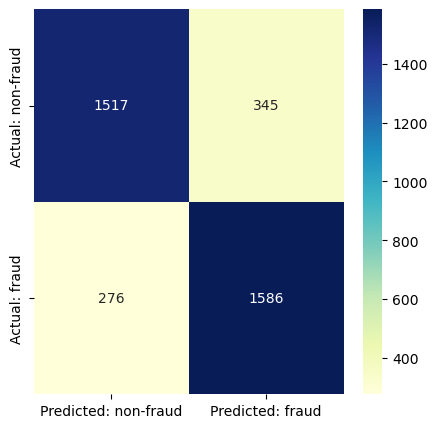

In [632]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(ytest,y_pred)
cm
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted: non-fraud','Predicted: fraud'],index=['Actual: non-fraud','Actual: fraud'])
plt.figure(figsize = (5,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");

In [633]:
TN=cm[0,0]
TP=cm[1,1]
FN=cm[1,0]
FP=cm[0,1]
sensitivity=TP/float(TP+FN)
specificity=TN/float(TN+FP)

In [634]:
print(' The acuuracy of the model = TP+TN/(TP+TN+FP+FN) =         ',round((TP+TN)/float(TP+TN+FP+FN),4),'\n',

'The Missclassification = 1-Accuracy =                     ',round(1-((TP+TN)/float(TP+TN+FP+FN)),4),'\n',

'Sensitivity or True Positive Rate = TP/(TP+FN) =          ',round(TP/float(TP+FN),4),'\n',

'Specificity or True Negative Rate = TN/(TN+FP) =          ',round(TN/float(TN+FP),4),'\n',
 
'Positive Predictive value = TP/(TP+FP) =                  ',round(TP/float(TP+FP),4),'\n',

'Negative predictive Value = TN/(TN+FN) =                  ',round(TN/float(TN+FN),4),'\n',

'Positive Likelihood Ratio = Sensitivity/(1-Specificity) = ',round(sensitivity/(1-specificity),4),'\n',

'Negative likelihood Ratio = (1-Sensitivity)/Specificity = ', ((1-sensitivity)/specificity))


 The acuuracy of the model = TP+TN/(TP+TN+FP+FN) =          0.8332 
 The Missclassification = 1-Accuracy =                      0.1668 
 Sensitivity or True Positive Rate = TP/(TP+FN) =           0.8518 
 Specificity or True Negative Rate = TN/(TN+FP) =           0.8147 
 Positive Predictive value = TP/(TP+FP) =                   0.8213 
 Negative predictive Value = TN/(TN+FN) =                   0.8461 
 Positive Likelihood Ratio = Sensitivity/(1-Specificity) =  4.5971 
 Negative likelihood Ratio = (1-Sensitivity)/Specificity =  0.18193803559657212


### Classification Report

In [635]:
from sklearn.metrics import classification_report
target_names = ['non-fraud', 'fraud']
print( "Classification Report")
print()
print(classification_report(ytest,y_pred,target_names=target_names))

Classification Report

              precision    recall  f1-score   support

   non-fraud       0.85      0.81      0.83      1862
       fraud       0.82      0.85      0.84      1862

    accuracy                           0.83      3724
   macro avg       0.83      0.83      0.83      3724
weighted avg       0.83      0.83      0.83      3724



In [636]:
combined_df = pd.concat([xtest, ytest], axis=1) 
combined_df['ypred_best'] = y_pred.tolist()
combined_df.head()
combined_df.to_csv('LogisticRegression_pred.csv')

### ROC Curve 

#### ROC curve (receiver operating characteristic curve) shows the performance of the classification model which plots TPR vs. FPR at different classification thresholds.

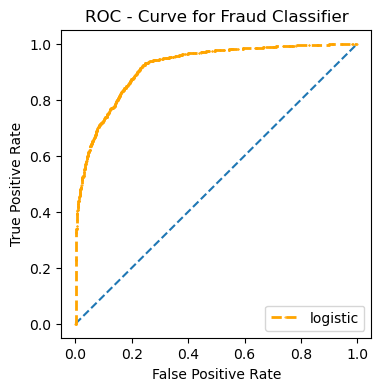

In [637]:
#define metrics
from sklearn import metrics
ns_probs = [0 for _ in range(len(ytest))]
#ns_auc = roc_auc_score(y3test, ns_probs)
y_pred_prob=logreg.predict_proba(xtest)[:,1]
fpr, tpr, _ = metrics.roc_curve(ytest,  y_pred_prob)
ns_fpr, ns_tpr, _ = metrics.roc_curve(ytest, ns_probs)
#create ROC curve
plt.figure(figsize =(4,4))
#plt.plot(fpr,tpr)
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(fpr,tpr, color='orange', marker='.', linestyle='--',linewidth=2, markersize=1,label='logistic' )
plt.title('ROC - Curve for Fraud Classifier')
plt.legend()
print()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


#### As we can see from the plot above,the ROC Curve is closer to the to the top left corner of the plot. Hence, we can say that the model is performing good towards calssifying the data point as fraud/non-fraud

#### To quantify this, we can calculate the AUC(area under the curve) which is an indicator of how much of the plot is located under the curve.

### AUC Curve

#### AUC ( Area under the ROC curve) which provides an aggregate measure of performance across all possible classification thresholds. AUC Ranges from 0 to 1. If a model predicts everything incorrectly, then AUC is 0 else if it predicts everything correctly then AUC is 1.

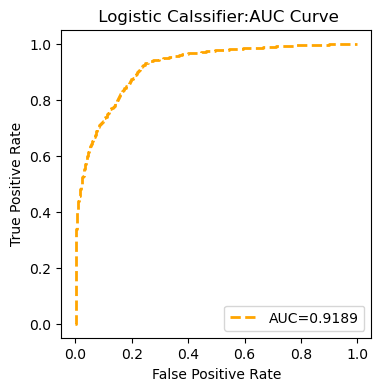

In [638]:
#define metrics

fpr, tpr, _ = metrics.roc_curve(ytest,  y_pred_prob)
auc = metrics.roc_auc_score(ytest, y_pred_prob)

#create ROC curve
plt.figure(figsize =(4,4))
plt.title(' Logistic Calssifier:AUC Curve')
plt.plot(fpr,tpr,label="AUC="+str(round(auc,4)),color='orange',  linestyle='dashed',linewidth=2, markersize=1)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

#### We can observe that AUC value is quite high. The Higher the AUC, the better the model is at distinguishing between fraudulent and non-fraudulent transaction

In [639]:
# #plotting ROC curve
# fpr, tpr, threshold = roc_curve(ytest, y_pred_prob)
# logistic_auc = roc_auc_score(ytest, y_pred_prob)
# plot_roc_curve(fpr, tpr, 'AUC = %.3f' % logistic_auc)

In [640]:
# #defining roc curve
# def plot_roc_curve(fpr, tpr, label=None):
#     plt.figure(figsize=(4,4))
#     plt.title('SVM classifier : ROC - AUC Curve')
#     print()
#     plt.plot([0, 1], [0, 1], 'k--')
#     #plt.plot(fpr, tpr, linewidth=2, label=label,color='orange')
#     plt.plot(fpr,tpr,label= "AUC="+str(round(auc,4)),color='orange',linewidth=2, markersize=1)
# #     plt.xticks(np.arange(0, 1, 0.05), rotation=90)
# #     plt.xlabel('False Positive Rates', fontsize=15)
# #     plt.ylabel('True Positive Rates', fontsize=15)
# #     plt.legend(loc='best')
#     plt.ylabel('True Positive Rate')
#     plt.xlabel('False Positive Rate')
#     plt.legend(loc='best')
#     plt.show()
    
#     plt.show()

## Hyperparameters tuning with GridSearchCV to improve model accuracy

#### The hyper parameters that we can tune for logistic regression are solver, penalty, and regularisation strength
#### Solvers are algorithms used for optimisation and there are multiple solvers like 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'
#### Penalty are 'none', 'l1','l2','elasticnet'
#### C is a parameter that controls penalty strength which is Inverse of regularization strength.smaller values specify stronger regularization.

In [641]:
# import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold

In [642]:
# create an instance of logistic regression
lr=LogisticRegression()

In [643]:
# defining the hyper parameters
param= {'C': [0.01,0.1, 0.5, 1,10,15,20], 'penalty': ['l1', 'l2','none']}

# create 5 folds for StratifiedKFold validation
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

#Gridsearch for hyperparam tuning
model= GridSearchCV(estimator= lr,param_grid=param,scoring="accuracy",cv=folds,return_train_score=True)

In [644]:
#train model to learn relationships between x and y
model.fit(xtrain,ytrain)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 0.5, 1, 10, 15, 20],
                         'penalty': ['l1', 'l2', 'none']},
             return_train_score=True, scoring='accuracy')

In [645]:
# print best hyperparameters
print("Best accuracy score: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best accuracy score:  0.8602318691691956
Best hyperparameters:  {'C': 0.01, 'penalty': 'none'}


In [646]:
#Building the model again with best params generated above

lr2=LogisticRegression(C=0.01,penalty="none")
lr2.fit(xtrain,ytrain)

LogisticRegression(C=0.01, penalty='none')

In [647]:
#predict labels on test dataset
y_pred_test = lr2.predict(xtest)

In [648]:
from sklearn import metrics
model_accuracy = metrics.accuracy_score(ytest, y_pred_test)
print(f'Logistic Regression Model accuracy after tuning : {round(model_accuracy,2)*100}% or {round(model_accuracy,2)}')

Logistic Regression Model accuracy after tuning : 86.0% or 0.86


### We can observe that after hyper parameter tuning with best parameters, the accuracy of the model has improved by 3%

In [649]:
# combined_df = pd.concat([xtest, ytest], axis=1) 
# combined_df['ypred_best'] = y_pred.tolist()
# combined_df.head()
# combined_df.to_csv('LogisticRegression_pred.csv')

In [650]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
print(" F1-Score        : " , round(f1_score(ytest,y_pred_test),4))
print(" Recall Score    : " , round(recall_score(ytest,y_pred_test),4))
print(" Precision Score : " , round(precision_score(ytest,y_pred_test),4))

 F1-Score        :  0.8614
 Recall Score    :  0.8528
 Precision Score :  0.8701


### There is improvement in precison and F1 score as well post tuning

In [651]:
from sklearn.metrics import classification_report
target_names = ['non-fraud', 'fraud']
print( "Classification Report")
print()
print(classification_report(ytest,y_pred_test,target_names=target_names))

Classification Report

              precision    recall  f1-score   support

   non-fraud       0.86      0.87      0.86      1862
       fraud       0.87      0.85      0.86      1862

    accuracy                           0.86      3724
   macro avg       0.86      0.86      0.86      3724
weighted avg       0.86      0.86      0.86      3724



### ROC Curve

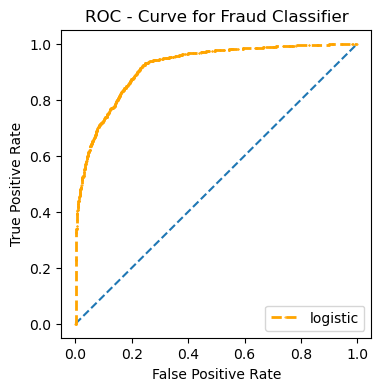

In [652]:
#define metrics
ns_probs = [0 for _ in range(len(ytest))]
#ns_auc = roc_auc_score(y3test, ns_probs)
y_pred_prob=logreg.predict_proba(xtest)[:,1]
fpr, tpr, _ = metrics.roc_curve(ytest,  y_pred_prob)
ns_fpr, ns_tpr, _ = metrics.roc_curve(ytest, ns_probs)
#create ROC curve
plt.figure(figsize =(4,4))
#plt.plot(fpr,tpr)
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(fpr,tpr, color='orange', marker='.', linestyle='--',linewidth=2, markersize=1,label='logistic' )
plt.title('ROC - Curve for Fraud Classifier')
plt.legend()
print()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### AUC Curve

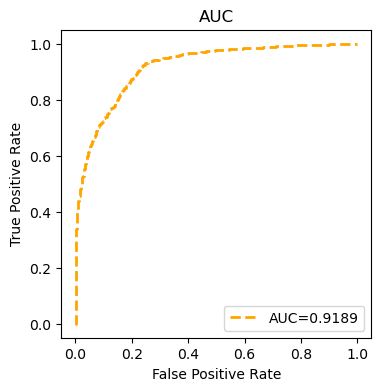

In [653]:
#define metrics

fpr, tpr, _ = metrics.roc_curve(ytest,  y_pred_prob)
auc = metrics.roc_auc_score(ytest, y_pred_prob)

#create ROC curve
plt.figure(figsize =(4,4))
plt.title('AUC')
plt.plot(fpr,tpr,label="AUC="+str(round(auc,4)),color='orange',  linestyle='dashed',linewidth=2, markersize=1)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [654]:
# #plotting ROC curve
# fpr, tpr, threshold = roc_curve(ytest, y_pred_prob)
# logistic_auc = roc_auc_score(ytest, y_pred_prob)
# plot_roc_curve(fpr, tpr, 'AUC = %.3f' % logistic_auc)

Comments and Analysis:

Overall, logistic regression is able to well clasiify the transactions as Fraud/non-fraud with tunes accracy of 86%

## Support Vector machines ( SVM )

#### Model Description:
Supervised Machine Learning Classification and Regression model
SVM aims to find the best hyperplane ( decision boundary ) which can separate 2 dimensional data into fraud/non-fraud class.


In [655]:
## Fitting the model
from sklearn import svm
#svc = svm.SVC(kernel='linear', C=1,gamma=0).fit(X, y)
from sklearn.svm import SVC
clf = svm.SVC(probability=True)
clf.fit(xtrain, ytrain)

SVC(probability=True)

In [656]:
#Predict the response for test dataset
y_pred = clf.predict(xtest)

### Model Accuracy

In [657]:
from sklearn import metrics
model_accuracy = metrics.accuracy_score(ytest, y_pred)
print(f'SVM model accuracy : {round(model_accuracy,2)*100}% or {round(model_accuracy,2)}')

SVM model accuracy : 82.0% or 0.82


### Metrics

In [658]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
print(" F1-Score        : " , round(f1_score(ytest,y_pred),4))
print(" Recall Score    : " , round(recall_score(ytest,y_pred),4))
print(" Precision Score : " , round(precision_score(ytest,y_pred),4))

 F1-Score        :  0.8253
 Recall Score    :  0.855
 Precision Score :  0.7976


### Classification Report

In [659]:
from sklearn.metrics import classification_report
target_names = ['non-fraud', 'fraud']
print( "Classification Report")
print()
print(classification_report(ytest,y_pred,target_names=target_names))

Classification Report

              precision    recall  f1-score   support

   non-fraud       0.84      0.78      0.81      1862
       fraud       0.80      0.85      0.83      1862

    accuracy                           0.82      3724
   macro avg       0.82      0.82      0.82      3724
weighted avg       0.82      0.82      0.82      3724



### Log Loss Function

In [660]:
# log loss of cost function
from sklearn import metrics
print(f' Log loss / Cost function : {round(metrics.log_loss(ytest, y_pred), 3)}')

 Log loss / Cost function : 6.251


The loss is 6.25 which is less. In comparison SVM has higher loss than logistic indicating the slight performance decrease

### Confusion Matrix

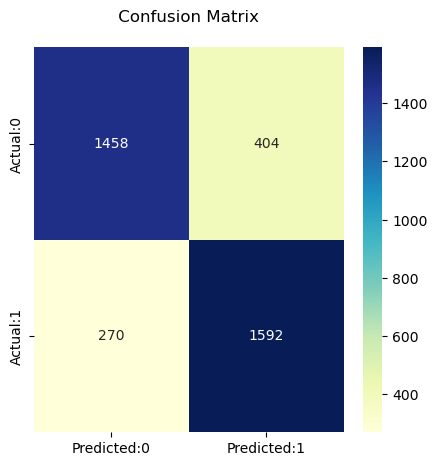

In [661]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(ytest,y_pred)
cm
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])

plt.figure(figsize = (5,5))
plt.title(" Confusion Matrix \n")
print()
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");

### ROC Curve

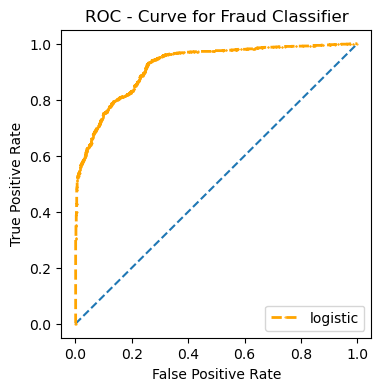

In [662]:
#define metrics
ns_probs = [0 for _ in range(len(ytest))]
#ns_auc = roc_auc_score(y3test, ns_probs)
y_pred_prob=clf.predict_proba(xtest)[:,1]
fpr, tpr, _ = metrics.roc_curve(ytest,  y_pred_prob)
ns_fpr, ns_tpr, _ = metrics.roc_curve(ytest, ns_probs)
#create ROC curve
plt.figure(figsize =(4,4))
#plt.plot(fpr,tpr)
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(fpr,tpr, color='orange', marker='.', linestyle='--',linewidth=2, markersize=1,label='logistic' )
plt.title('ROC - Curve for Fraud Classifier')
plt.legend()
print()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### AUC Curve

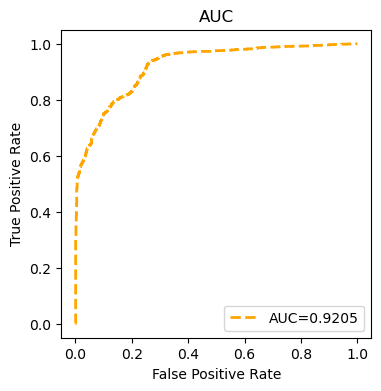

In [663]:
#define metrics

fpr, tpr, _ = metrics.roc_curve(ytest,  y_pred_prob)
auc = metrics.roc_auc_score(ytest, y_pred_prob)

#create ROC curve
plt.figure(figsize =(4,4))
plt.title('AUC')
plt.plot(fpr,tpr,label="AUC="+str(round(auc,4)),color='orange',  linestyle='dashed',linewidth=2, markersize=1)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Comments:The AUC for SVM is closer to 1. Indicating model does a good job in predicting fraudulent transactions.

## Hyper parameter tuning to improve SVMs model accuracy

Description:
Tuning the parameters values for machine learning algorithms effectively improves model performance. Hence, here 

GridSearch CV is used to find the hyper parameters.The main idea behind it is to create a grid of hyper-parameters and just try all of their combinations to find the best parameter that the model can be fit on in order to improve the accuracy.The grid of parameters is defined as a dictionary, where the keys are the parameters and the values are the settings to be tested.

SVM has some hyoer parameters like C, gamma

In [664]:
from sklearn.model_selection import GridSearchCV


In [665]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 

In [666]:
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

In [667]:
# fitting the model for grid search
grid.fit(xtrain, ytrain)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.819 total time=  11.6s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.800 total time=   8.7s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.816 total time=   7.9s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.807 total time=   8.5s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.819 total time=   7.8s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.815 total time=   8.1s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.800 total time=   7.4s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.816 total time=  10.3s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.805 total time=   7.8s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.817 total time=   7.6s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.815 total time=   9.7s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 2/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.848 total time=  44.9s
[CV 3/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.854 total time=  39.4s
[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.860 total time= 1.1min
[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.859 total time=  29.6s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.872 total time=  15.4s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.867 total time=  21.8s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.873 total time=  14.6s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.873 total time=  14.9s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.872 total time=  14.4s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.869 total time=  24.3s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.854 total time=   9.1s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.868 total time=   8.4s
[CV 4/5] END ....C=1000, gam

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [668]:
# print best parameter after tuning
print(grid.best_params_)

{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}


In [669]:
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

SVC(C=1000, gamma=0.1)


In [670]:
# calculate the predictions
grid_predictions = grid.predict(xtest)

In [671]:
combined_df = pd.concat([xtest, ytest], axis=1) 
combined_df['ypred_best'] = grid_predictions.tolist()
combined_df.head()
combined_df.to_csv('SVM_pred.csv')

### Model accuracy

In [672]:
from sklearn import metrics
model_accuracy = metrics.accuracy_score(ytest, grid_predictions)
print(f'SVM model accuracy : {round(model_accuracy,2)*100}% or {round(model_accuracy,2)}')

SVM model accuracy : 88.0% or 0.88


### The model accuracy has increased to 88% from 82% after hyper parameter tuning

### Metrics

In [673]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
print(" F1-Score        : " , round(f1_score(ytest,grid_predictions),4))
print(" Recall Score    : " , round(recall_score(ytest,grid_predictions),4))
print(" Precision Score : " , round(precision_score(ytest,grid_predictions),4))

 F1-Score        :  0.8801
 Recall Score    :  0.8813
 Precision Score :  0.879


### F1 Score, recall, precision are aslo improved after tuning

### Classification matrix

In [674]:
from sklearn.metrics import classification_report
target_names = ['non-fraud', 'fraud']
print( "Classification Report")
print()
print(classification_report(ytest,grid_predictions,target_names=target_names))

Classification Report

              precision    recall  f1-score   support

   non-fraud       0.88      0.88      0.88      1862
       fraud       0.88      0.88      0.88      1862

    accuracy                           0.88      3724
   macro avg       0.88      0.88      0.88      3724
weighted avg       0.88      0.88      0.88      3724



In [675]:
# log loss of cost function
from sklearn import metrics
print(f' Log loss / Cost function : {round(metrics.log_loss(ytest, grid_predictions), 3)}')

 Log loss / Cost function : 4.146


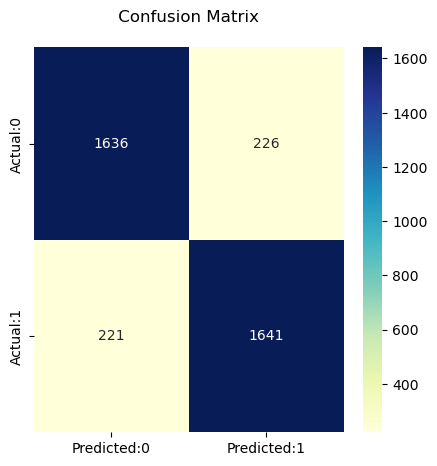

In [676]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(ytest,grid_predictions)
cm
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])

plt.figure(figsize = (5,5))
plt.title(" Confusion Matrix \n")
print()
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");

### ROC Curve

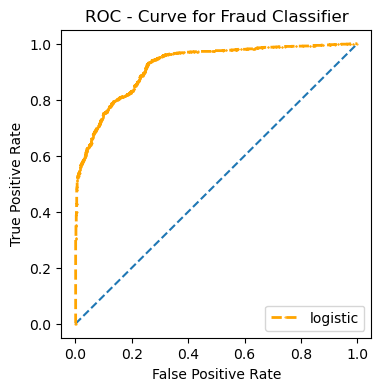

In [677]:
#define metrics
ns_probs = [0 for _ in range(len(ytest))]
#ns_auc = roc_auc_score(y3test, ns_probs)
y_pred_prob=clf.predict_proba(xtest)[:,1]
fpr, tpr, _ = metrics.roc_curve(ytest,  y_pred_prob)
ns_fpr, ns_tpr, _ = metrics.roc_curve(ytest, ns_probs)
#create ROC curve
plt.figure(figsize =(4,4))
#plt.plot(fpr,tpr)
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(fpr,tpr, color='orange', marker='.', linestyle='--',linewidth=2, markersize=1,label='logistic' )
plt.title('ROC - Curve for Fraud Classifier')
plt.legend()
print()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### AUC Curve

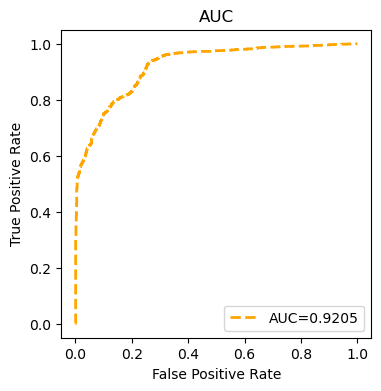

In [678]:
#define metrics

fpr, tpr, _ = metrics.roc_curve(ytest,  y_pred_prob)
auc = metrics.roc_auc_score(ytest, y_pred_prob)

#create ROC curve
plt.figure(figsize =(4,4))
plt.title('AUC')
plt.plot(fpr,tpr,label="AUC="+str(round(auc,4)),color='orange',  linestyle='dashed',linewidth=2, markersize=1)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### Overall,the model has given better accuracy after hyper parameter tuning.